In [1]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from importlib import reload

from build_dct_unitary_dictionary import build_dct_unitary_dictionary

from im2col import im2col
from col2im import col2im
from compute_psnr import compute_psnr

#CCH 20200520 widthen display output
np.set_printoptions(formatter={'float': lambda x: " {0:7.3f}".format(x)})


In [2]:
def showResult(estimate_image, orig_image):
    cmap_range = 5.0

    fig = plt.figure(1, figsize=[15, 10])
    plt.subplot(1, 3, 1)
    plt.imshow(im, 'gray', vmin=0, vmax=255)
    plt.title('Original image')

    plt.subplot(1, 3, 2)
    plt.imshow(estimate_image, 'gray', vmin=0, vmax=255)
    plt.title('Recovered image')

    psnr = compute_psnr(estimate_image, orig_image)
    delta_ref = orig_image - estimate_image

    plt.subplot(1, 3, 3)
    plt.title('Delta G.T. (PSNR = {:.2f})'.format(psnr))
    plt.imshow(delta_ref, 'coolwarm', vmin=-cmap_range, vmax=cmap_range)

    plt.show()

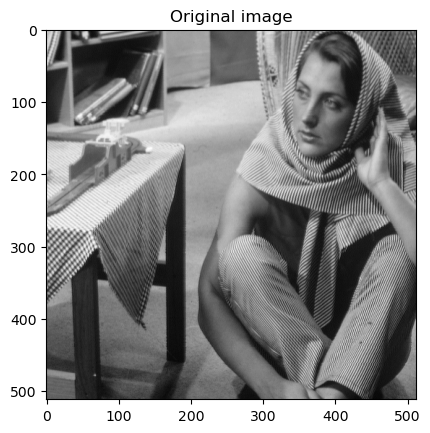

In [3]:
# Read an image
im = np.array(Image.open('barbara.png'))
# im = np.array(Image.open('misc\\brain4.jpg'))

# Show the image
plt.figure(0)
plt.imshow(im,'gray') 
plt.title('Original image')
plt.show()

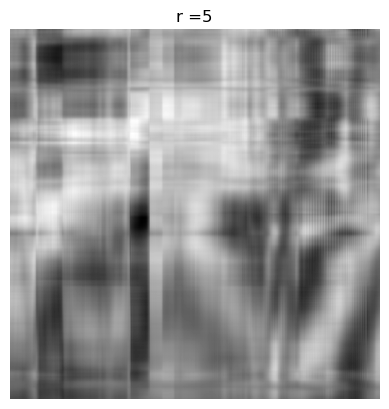

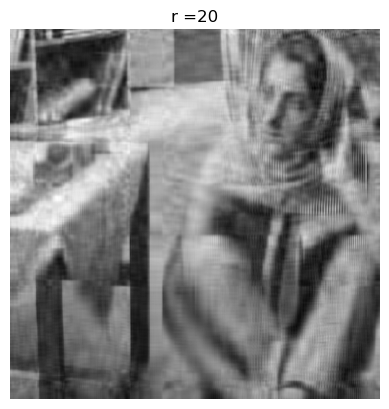

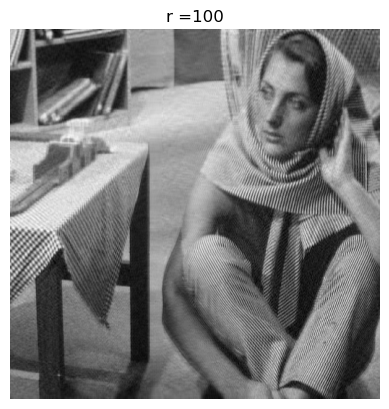

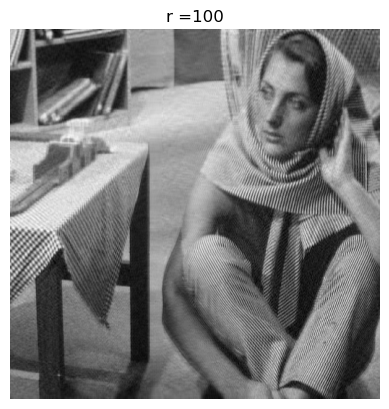

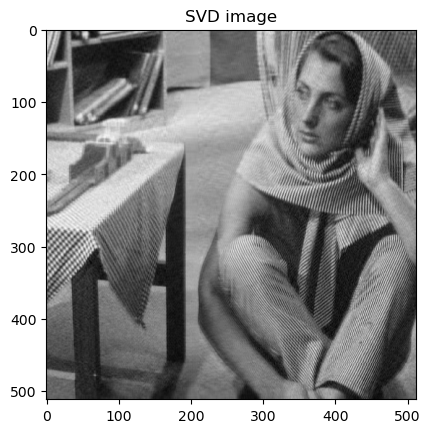

In [4]:
#use svd on image
X = im
#image compression with svd

#turn image to matrix X=USV.t

U,S,VT=np.linalg.svd(X,full_matrices=False)

S= np.diag(S)
#print(S)

j=0
#Going throught rank 5,20,100 of matrice
#Then chose first r columns to get optimal solution
for r in (5,20,100):
#Construct approximate image
    Xapprox = U[:,:r]@ S[0:r,:r] @ VT[:r,:]
    plt.figure(j+1)
    j += 1
    img = plt.imshow(Xapprox)
    img.set_cmap('gray')
    plt.axis('off')
    plt.title('r =' + str(r))
    plt.show()
    
Xapprox2 = U[:,:100]@ S[0:100,:100] @ VT[:100,:]
    
img = plt.imshow(Xapprox2)
img.set_cmap('gray')
plt.axis('off')
plt.title('r =' + str(r))
plt.show()

im = Xapprox2

# im = np.array(Image.open('misc\\brain4.jpg'))

# Show the image
plt.figure(0)
plt.imshow(im,'gray') 
plt.title('SVD image')
plt.show()



<H2>Create DCT dictionary</H2> 

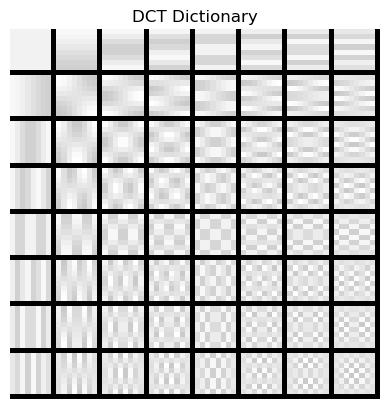

In [35]:
import show_dictionary as showdict
reload(showdict)

# Patch dimensions [height, width]
dim = 8
patch_size = [dim, dim]

D_DCT = build_dct_unitary_dictionary(patch_size)
showdict.showDictionary(D_DCT, 'DCT Dictionary')


<H2>Recover patches by OMP</H2>

In [36]:
import omp as omplib
reload(omplib)

# Create the patches from the original image, fully overlapping => stepsize =1
patches = im2col(im, dim, stepsize=1)

# the patches are flattened alongside the y axis (size = dim*dim)
print(patches.shape)

# CCH 20230804 maximum number of atoms per patch
k = 6

# CCH 20230804 maximum deviation per patch
epsilon = 0.02

est_patches, est_coeffs = omplib.omp(D_DCT, patches, k, epsilon)

(64, 255025)


In [37]:
# CCH 20230804 Convert the patches back into one image with the original size
estimate_image = col2im(est_patches, dim, im.shape)

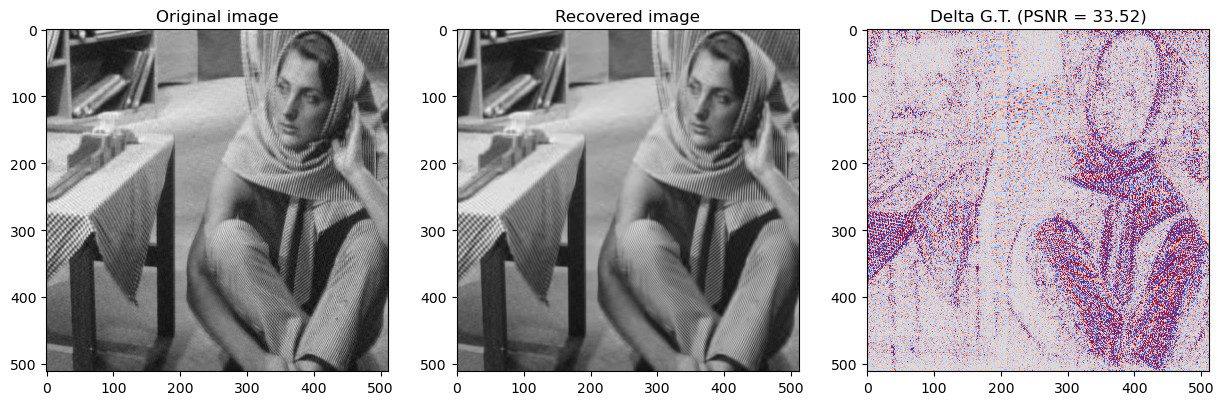

In [38]:
showResult(estimate_image, im)

<h2>KSVD Dictionary learning</h2>

In [39]:
import ksvd_dictionary_learning as ksvdl
reload(ksvdl)

num_learning_iterations = 12
k = 4
epsilon = 0.02
train_percentage = 10
no_patches = patches.shape[1]
starting_dict = D_DCT

patch_random = np.random.permutation(no_patches)
max_idx = int(no_patches * train_percentage / 100)
train_patches = patches[:, patch_random[1:max_idx]]
print(train_patches.shape)
        
D_ksvd, mean_error, mean_cardinality = ksvdl.ksvd_dictionary_learning(train_patches, starting_dict, num_learning_iterations, k, epsilon)

(64, 25501)
-------K-SVD iteration 1
omp start
KSVD iteration start
-------K-SVD iteration 2
omp start
KSVD iteration start
-------K-SVD iteration 3
omp start
KSVD iteration start
-------K-SVD iteration 4
omp start
KSVD iteration start
-------K-SVD iteration 5
omp start
KSVD iteration start
-------K-SVD iteration 6
omp start
KSVD iteration start
-------K-SVD iteration 7
omp start
KSVD iteration start
-------K-SVD iteration 8
omp start
KSVD iteration start
-------K-SVD iteration 9
omp start
KSVD iteration start
-------K-SVD iteration 10
omp start
KSVD iteration start
-------K-SVD iteration 11
omp start
KSVD iteration start
-------K-SVD iteration 12
omp start
KSVD iteration start
KSVD learning finished


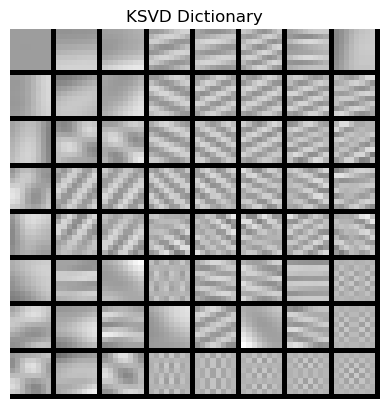

-0.0019440678335322994


In [40]:
showdict.showDictionary(D_ksvd, 'KSVD Dictionary')
print(np.average(D_ksvd))


<H2>Recover patches with a KSVD learned dictionary </H2>

In [41]:
k = 6
epsilon = 0.02
est_patches_ksvd, est_coeffs = omplib.omp(D_ksvd, patches, k, epsilon)

In [42]:
# CCH 20230804 Convert the patches back into one image with the original size
estimate_image_ksvd = col2im(est_patches_ksvd, dim, im.shape)

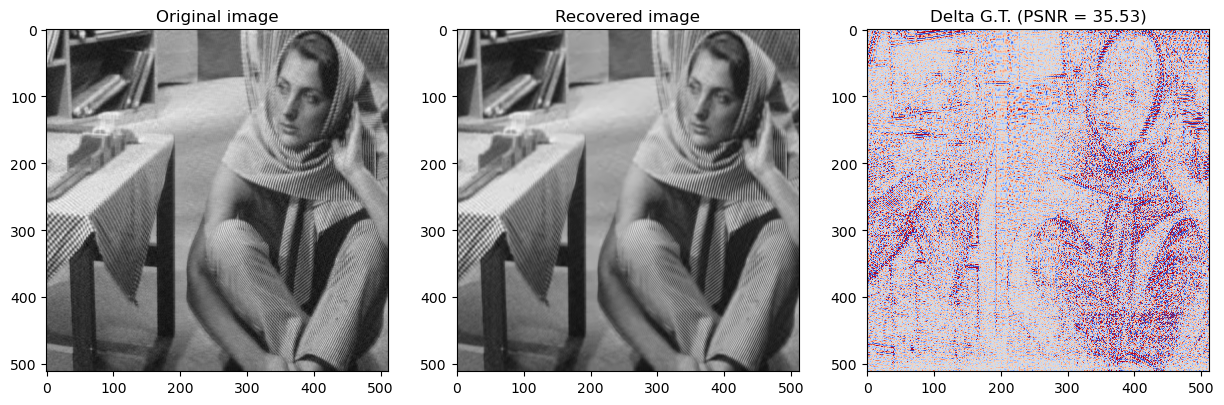

In [43]:
showResult(estimate_image_ksvd, im)

### I improved psnr by 1 point using svd compression on image when reading